In [154]:
import numpy as np
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from scipy.constants import mu_0
from scipy.constants import elementary_charge as q_e
from scipy.constants import proton_mass as m_i
from astropy.convolution import convolve, convolve_fft
from scipy.signal import fftconvolve
from scipy.interpolate import SmoothBivariateSpline
import write_canonical_flux_tube_quantities as wcf
reload(wcf)

from datetime import date
from datetime import datetime
import visit_writer

import structured_3d_vtk as struc_3d
reload(struc_3d)

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

import os

import ion_current_to_mach_number as ic_to_mach
reload(ic_to_mach)

import read_from_sql

from mpl_toolkits.mplot3d import Axes3D

# Read idl files and generate inteprolators

In [2]:
bx_all_planes = wcf.save_idl_quantity_to_unstructured_grids('bx', 'B_x', 'now',
                                                            x_min=-0.032, x_max=0.028,
                                                            y_min=-0.022, y_max=0.032, 
                                                            z_min=0.249, z_max=0.416)
by_all_planes = wcf.save_idl_quantity_to_unstructured_grids('by', 'B_y', 'now',
                                                            x_min=-0.032, x_max=0.028,
                                                            y_min=-0.022, y_max=0.032, 
                                                            z_min=0.249, z_max=0.416)
bz_all_planes = wcf.save_idl_quantity_to_unstructured_grids('bz', 'B_z', 'now',
                                                            x_min=-0.032, x_max=0.028,
                                                            y_min=-0.022, y_max=0.032, 
                                                            z_min=0.249, z_max=0.416)
te_all_planes = wcf.save_idl_quantity_to_unstructured_grids('te', 'T_e', 'now', 
                                                            x_min=-0.026, x_max=0.028,
                                                            y_min=-0.03, y_max=0.028, 
                                                            z_min=0.249, z_max=0.416,
                                                            bounds=(1e-3, 1e3))
n_all_planes = wcf.save_idl_quantity_to_unstructured_grids('n', 'n', 'now',
                                                           x_min=-0.026, x_max=0.028,
                                                           y_min=-0.03, y_max=0.028, 
                                                           z_min=0.249, z_max=0.416,
                                                           bounds=(1e3, 1e22))
n_three_planes = wcf.remove_plane(0.302, n_all_planes)
te_three_planes = wcf.remove_plane(0.302, te_all_planes)

n_all_planes = n_three_planes
te_all_planes = te_three_planes

bx_triangulation, bx_interpolators = wcf.give_delaunay_and_interpolator(bx_all_planes)
by_triangulation, by_interpolators = wcf.give_delaunay_and_interpolator(by_all_planes)
bz_triangulation, bz_interpolators = wcf.give_delaunay_and_interpolator(bz_all_planes)
te_triangulation, te_interpolators = wcf.give_delaunay_and_interpolator(te_all_planes)
n_triangulation, n_interpolators = wcf.give_delaunay_and_interpolator(n_all_planes)

# Read Mach measurements from database and build interpolators

In [3]:
timesteps = 250

database = '/home/jensv/rsx/jens_analysis/shots_database/source/shots.db'
table = 'Shots'
z_direction_1, z_direction_2 = 0, 180
y_direction_1, y_direction_2 = 90, 270
angle_signs = {0: 1,
               180: -1,
               90: -1,
               0: 1}
min_spectral_density = 1.6e-8

condition_z_0416 = ("campaigns = 'mach_probe_plane_campaign_1'"
                    " AND fiducial_pre_crowbar_gyration_spectral_density > "
                    + str(min_spectral_density) +
                    " AND mach_signals_exist = 1"
                    " AND (mach_orientation = " + str(z_direction_1) +
                    " OR mach_orientation = " + str(z_direction_2) + ")")

condition_y_0416 = ("campaigns = 'mach_probe_plane_campaign_1'"
                    " AND fiducial_pre_crowbar_gyration_spectral_density > "
                    + str(min_spectral_density) +
                    " AND mach_signals_exist = 1"
                    " AND (mach_orientation = " + str(y_direction_1) +
                    " OR mach_orientation = " + str(y_direction_2) + ")")

cursor, connection = read_from_sql.cursor_with_rows(condition_z_0416,
                                                    database,
                                                    table)
z_0416_shots = cursor.fetchall()
cursor.close()
connection.close()

cursor, connection = read_from_sql.cursor_with_rows(condition_y_0416,
                                                    database,
                                                    table)
y_0416_shots = cursor.fetchall()
cursor.close()
connection.close()

condition_z_302 = ("campaigns = 'mach_probe_plane_campaign_2'"
                   " AND fiducial_pre_crowbar_gyration_spectral_density > "
                   + str(min_spectral_density) +
                   " AND mach_signals_exist = 1"
                   " AND (mach_orientation = " + str(z_direction_1) +
                   " OR mach_orientation = " + str(z_direction_2) + ")")

cursor, connection = read_from_sql.cursor_with_rows(condition_z_302,
                                                    database,
                                                    table)
z_0302_shots = cursor.fetchall()
cursor.close()
connection.close()

mach_z_0416_measurements = ic_to_mach.run_mach_analysis(z_0416_shots,
                                                        timesteps, 
                                                        angle_signs) 
mach_y_0416_measurements = ic_to_mach.run_mach_analysis(y_0416_shots,
                                                        timesteps, 
                                                        angle_signs)
mach_z_0302_measurements = ic_to_mach.run_mach_analysis(z_0302_shots,
                                                        timesteps, 
                                                        angle_signs)

mach_z_0416_measurements['delays'] = np.arange(timesteps)
mach_y_0416_measurements['delays'] = np.arange(timesteps)
mach_z_0302_measurements['delays'] = np.arange(timesteps)

mach_z_0416_measurements = struc_3d.average_duplicate_points(mach_z_0416_measurements)
mach_y_0416_measurements = struc_3d.average_duplicate_points(mach_y_0416_measurements)
mach_z_0302_measurements = struc_3d.average_duplicate_points(mach_z_0302_measurements)

mach_y_measurements = {0.416: mach_y_0416_measurements}
mach_z_measurements = {0.302: mach_z_0302_measurements,
                       0.416: mach_z_0416_measurements}

mach_y_all_planes = wcf.save_quantity_to_unstructured_grids(mach_y_measurements, 
                                                            'Mach_y', 'Mach_y', '2016-07-26',
                                                            planes=[0.416],
                                                            x_min=-0.052, x_max=0.052,
                                                            y_min=-0.022, y_max=0.032, 
                                                            z_min=0.249, z_max=0.416,
                                                            bounds=(-10, 10))

mach_z_all_planes = wcf.save_quantity_to_unstructured_grids(mach_z_measurements, 
                                                            'Mach_z', 'Mach_z', '2016-07-26',
                                                            planes=[0.302, 0.416],
                                                            x_min=-0.032, x_max=0.032,
                                                            y_min=-0.022, y_max=0.032, 
                                                            z_min=0.249, z_max=0.416,
                                                            bounds=(-10, 10))
mach_y_all_planes = wcf.remove_nan_points(mach_y_all_planes)
mach_z_all_planes = wcf.remove_nan_points(mach_z_all_planes)

mach_y_triangulation, mach_y_interpolators = wcf.give_delaunay_and_interpolator(mach_y_all_planes)
mach_z_triangulation, mach_z_interpolators = wcf.give_delaunay_and_interpolator(mach_z_all_planes)

# Just work on timestep 0

In [8]:
time_point = 0

# Interpolate Temperature and density

In [9]:
(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mesh_wo_edges = wcf.remove_edges_mesh([np.array(mesh[0]), 
                                       np.array(mesh[1]), 
                                       np.array(mesh[2])])
ones = np.ones(mesh_wo_edges[0].shape)


te_interpolator = te_interpolators[time_point]
n_interpolator = n_interpolators[time_point]
    
temperature = wcf.scalar_on_mesh(te_interpolator, mesh_wo_edges)
density = wcf.scalar_on_mesh(n_interpolator, mesh_wo_edges)
b_field, b_field_norm = wcf.b_field_on_mesh([bx_interpolators[time_point], 
                                             by_interpolators[time_point],
                                             bz_interpolators[time_point]], 
                                             mesh_wo_edges, 
                                             bias=2e-2)

In [10]:
temperature_plane_normalized = temperature / np.nanmax(np.nanmax(temperature, 0), 0)[None, None, :]

# Determine ion_velocity_term1

In [15]:
alpha = 1
filter_width = 15

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mesh_wo_edges = wcf.remove_edges_mesh([np.array(mesh[0]), 
                                       np.array(mesh[1]), 
                                       np.array(mesh[2])])
ones = np.ones(mesh_wo_edges[0].shape)

time_point = 200

bx_interpolator = bx_interpolators[time_point]
by_interpolator = by_interpolators[time_point]
bz_interpolator = bz_interpolators[time_point]
te_interpolator = te_interpolators[time_point]
n_interpolator = n_interpolators[time_point]

bx_derivative = wcf.triangulate_derivatives(mesh, bx_triangulation, bx_interpolator, 
                                            increment=0.0000001)
bx_derivative = wcf.remove_edges_derivative_meshes(bx_derivative)
by_derivative = wcf.triangulate_derivatives(mesh, by_triangulation, by_interpolator, 
                                            increment=0.0000001)
by_derivative = wcf.remove_edges_derivative_meshes(by_derivative)
bz_derivative = wcf.triangulate_derivatives(mesh, bz_triangulation, bz_interpolator, 
                                            increment=0.0000001)
bz_derivative = wcf.remove_edges_derivative_meshes(bz_derivative)


current = wcf.current_on_mesh([bx_derivative, 
                               by_derivative, 
                               bz_derivative])
b_field, b_field_norm = wcf.b_field_on_mesh([bx_interpolator, 
                                             by_interpolator,
                                             bz_interpolator], 
                                            mesh_wo_edges, 
                                            bias=2e-2)

temperature = wcf.scalar_on_mesh(te_interpolator, mesh_wo_edges)
density = wcf.scalar_on_mesh(n_interpolator, mesh_wo_edges)

current = np.asarray(current)
density = np.asarray(density)
b_field_norm = np.asarray(b_field_norm)

density = wcf.boxcar_filter_quantity_mesh(density, filter_width)

for direction in xrange(len(current)):
    current[direction] = wcf.boxcar_filter_quantity_mesh(current[direction], filter_width)

density_constant = 1e18*np.ones(density.shape)

ion_velocity_term_1 = wcf.calc_ion_velocity_term_1(current, density, q_e)
ion_velocity_term_1_constant_density = wcf.calc_ion_velocity_term_1(current, density_constant, q_e)
ion_velocity_term_2 = wcf.calc_ion_velocity_term_2(b_field_norm, alpha)

ion_vorticity_term_1 = wcf.calc_ion_vorticity_term_1(current, density, q_e, mesh_wo_edges)
ion_vorticity_term_1_constant_density = wcf.calc_ion_vorticity_term_1(current, density_constant, q_e, mesh_wo_edges)
ion_vorticity_term_2 = wcf.calc_ion_vorticity_term_2(b_field_norm, alpha, mesh_wo_edges)

mesh_wo_edges = wcf.remove_edges_mesh([np.array(mesh[0]), 
                                       np.array(mesh[1]), 
                                       np.array(mesh[2])])

# Determine measured ion_velocity u_i

In [11]:
(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mach_y_interpolator = mach_y_interpolators[0]
mach_z_interpolator = mach_z_interpolators[0]
te_interpolator = te_interpolators[0]
 
mach_y = wcf.scalar_on_mesh(mach_y_interpolator, mesh[:2])
mach_z = wcf.scalar_on_mesh(mach_z_interpolator, mesh)
te = wcf.scalar_on_mesh(te_interpolator, mesh)

u_i_y = np.sqrt(te*q_e/m_i)*mach_y
u_i_z = np.sqrt(te*q_e/m_i)*mach_z

u_i_y = np.reshape(u_i_y, mesh[0].shape)
u_i_z = np.reshape(u_i_z, mesh[0].shape)

u_i_y = wcf.remove_edges_scalar_quantity_meshes(u_i_y)
u_i_z = wcf.remove_edges_scalar_quantity_meshes(u_i_z)

In [137]:
np.nanmax(u_i_y)

8929.1084724598186

In [138]:
np.sum(np.isnan(u_i_z[:,:,-1]))

18

In [196]:
alpha_from_y = (u_i_y - ion_velocity_term_1[1])/ b_field_norm[1]
alpha_from_z = (u_i_z - ion_velocity_term_1[2])/ b_field_norm[2]

alpha_from_y_flattened_z04 = alpha_from_y[:,:,-1].ravel()
alpha_from_z_flattened_z04 = alpha_from_z[:,:,-1].ravel()
points_x = mesh_wo_edges[0][:, :, -1].ravel()
points_y = mesh_wo_edges[1][:, :, -1].ravel()
points_z_z04 = mesh[2][0,0,-1]*np.ones(points_x.shape)
std_z04 = np.expand_dims(np.zeros(points_x.shape), 0)

data_y_z04 = {'a_out': np.expand_dims(alpha_from_y_flattened_z04, 0),
              'x_out': points_x,
              'y_out': points_y,
              'z_out': points_z_z04,
              'std': std_z04,
              'delays': np.asarray([0])
              }
data_z_z04 = {'a_out': np.expand_dims(alpha_from_z_flattened_z04, 0),
              'x_out': points_x,
              'y_out': points_y,
              'z_out': points_z_z04,
              'std': std_z04,
              'delays': np.asarray([0])
              }

data_y_z04 = wcf.remove_nan_points(data_y_z04)
data_z_z04 = wcf.remove_nan_points(data_z_z04)

positions_to_remove = np.where(np.abs(data_y_z04['a_out'][0]) > np.abs(np.nanmean(data_y_z04['a_out'][0])*10000))

data_y_z04 = wcf.remove_positions(data_y_z04, positions_to_remove)

alpha_z_z04_triangulation, alpha_z_z04_interpolators = wcf.give_delaunay_and_interpolator(data_z_z04)
alpha_y_z04_triangulation, alpha_y_z04_interpolators = wcf.give_delaunay_and_interpolator(data_y_z04)

In [198]:
alpha_z_test = wcf.scalar_on_mesh(alpha_z_z04_interpolators[0], [mesh_wo_edges[0], mesh_wo_edges[1]])

In [199]:
alpha_z_test[:,:,0]

array([[ -30077.57317871,  -60317.53409594,  -83945.60543762, ...,
                     nan,              nan,              nan],
       [ -24172.56616334,  -52930.03485501,  -75860.94706965, ...,
                     nan,              nan,              nan],
       [ -25460.53950678,  -52881.84019926,  -75449.10563471, ...,
                     nan,              nan,              nan],
       ..., 
       [ 160201.14996867,  160581.38801274,  149006.56772032, ...,
         -41786.37041175,  -57642.57408448,  -68499.09991186],
       [ 154431.3674436 ,  153465.55377865,  141361.86435311, ...,
         -42818.10227969,  -61058.45642014,  -72434.65955998],
       [ 146562.53698349,  145970.77180753,  133290.99516214, ...,
         -43687.2102599 ,  -62541.54368526,  -74359.49916604]])

In [200]:
alpha_y_test = wcf.scalar_on_mesh(alpha_y_z04_interpolators[0], [mesh_wo_edges[0], mesh_wo_edges[1]])

In [201]:
alpha_y_test[:,:,0]

array([[               nan,                nan,                nan, ...,
           285954.10951832,    426475.28988049,    624614.36836762],
       [               nan,                nan,                nan, ...,
           272756.9053244 ,    428976.51681497,    672152.82055234],
       [ 30207268.71725059,   5299836.3789051 ,   9344650.09128232, ...,
           259414.40707432,    426437.64649644,    764486.00349077],
       ..., 
       [ -1536147.88456737,   -930079.78126382,   -842710.97106707, ...,
          -239301.97508233,   -399090.42627732,   -638503.82669624],
       [  -724056.67279946,  -1098348.44289134,  -1005817.6564336 , ...,
          -215513.24735606,   -363933.14715519,   -592296.73030254],
       [  -690000.56215443,  -1510926.81595522,  -1308806.91157997, ...,
          -207686.64807922,   -360412.0558619 ,   -562901.79855643]])

# Compare contour plots of ion velocities

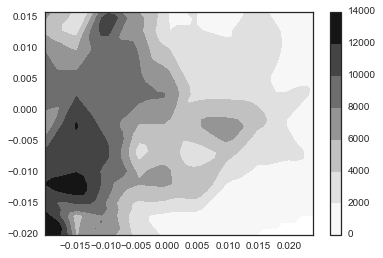

In [202]:
plt.contourf(mesh_wo_edges[0][:,:,0], mesh_wo_edges[1][:,:,0],
             u_i_z[:,:,-1])
plt.colorbar()
plt.show()

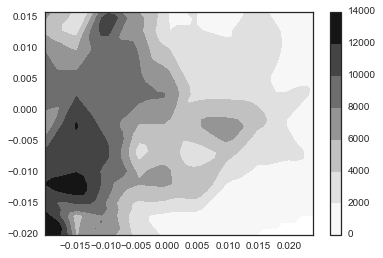

In [203]:
plt.contourf(mesh_wo_edges[0][:,:,0], mesh_wo_edges[1][:,:,0],
             b_field_norm[2][:, :, -1]*alpha_test[:,:,-1]
             + ion_velocity_term_1[2][:, :, -1])
plt.colorbar()
plt.show()

# Now look at y using alpha_z interpolation

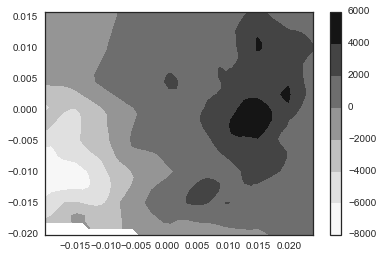

In [204]:
plt.contourf(mesh_wo_edges[0][:,:,0], mesh_wo_edges[1][:,:,0],
             u_i_y[:,:,-1])
plt.colorbar()
plt.show()

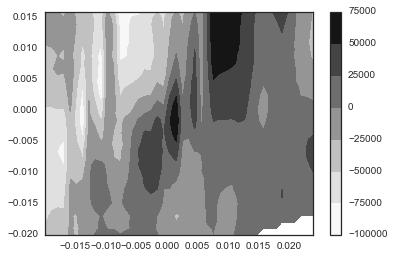

In [205]:
plt.contourf(mesh_wo_edges[0][:,:,0], mesh_wo_edges[1][:,:,0],
             b_field_norm[1][:, :, -1]*alpha_test[:,:,-1]
             + ion_velocity_term_1[1][:, :, -1])
plt.colorbar()
plt.show()

# Now look at u_y using alpha_y interpolation

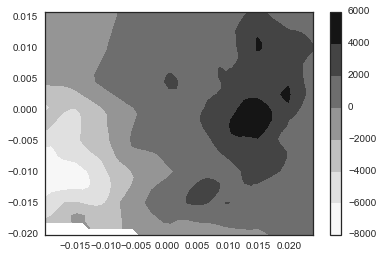

In [206]:
plt.contourf(mesh_wo_edges[0][:,:,0], mesh_wo_edges[1][:,:,0],
             u_i_y[:,:,-1])
plt.colorbar()
plt.show()

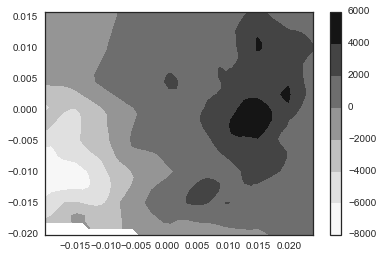

In [207]:
plt.contourf(mesh_wo_edges[0][:,:,0], mesh_wo_edges[1][:,:,0],
             b_field_norm[1][:, :, -1]*alpha_y_test[:,:,-1]
             + ion_velocity_term_1[1][:, :, -1])
plt.colorbar()
plt.show()

In [208]:
alpha_y_test_smooth = wcf.boxcar_filter_quantity_mesh(alpha_y_test, 15)

TypeError: __init__() got an unexpected keyword argument 'vmax'

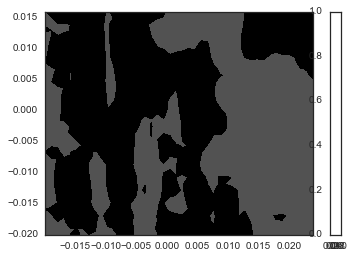

In [214]:
plt.contourf(mesh_wo_edges[0][:,:,0], mesh_wo_edges[1][:,:,0],
             b_field_norm[0][:, :, -1]*alpha_y_test[:,:,-1]
             + ion_velocity_term_1[0][:, :, -1], vmax=1e5)

plt.show()

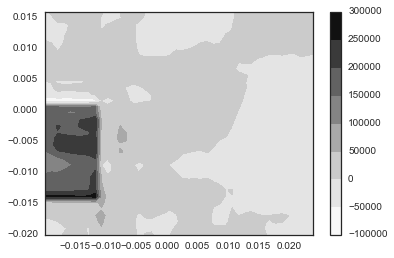

In [210]:
plt.contourf(mesh_wo_edges[0][:,:,0], mesh_wo_edges[1][:,:,0],
             b_field_norm[0][:, :, -1]*alpha_y_test_smooth[:,:,-1]
             + ion_velocity_term_1[0][:, :, -1])
plt.colorbar()
plt.show()

In [109]:
np.max(ion_velocity_term_1[0][:, :, -1])

43078.073341196854

In [114]:
np.max(ion_velocity_term_1[1][:, :, -1])

73741.779399923471

In [112]:
np.max(b_field_norm[1][:, :, -1])

0.03517617578731113

In [113]:
np.max(b_field_norm[0][:, :, -1])

0.038437629454094374

In [103]:
np.nanmean(ion_velocity_term_1[0][:, :, -1] / ion_velocity_term_1[1][:, :, -1])

-0.93735255358298131

In [115]:
np.nanmax(b_field_norm[0][:, :, -1]*alpha_y_test[:,:,-1] + ion_velocity_term_1[0][:, :, -1])

120653116.33147749

In [120]:
np.where((b_field_norm[0][:, :, -1]*alpha_y_test[:,:,-1] + ion_velocity_term_1[0][:, :, -1]) > 1.2e8)

(array([13]), array([1]))

In [122]:
(b_field_norm[0][:, :, -1]*alpha_y_test[:,:,-1] + ion_velocity_term_1[0][:, :, -1])[13,1]

120653116.33147749

In [125]:
b_field_norm[0][13, 1, -1]

-0.11664500853610586

In [128]:
alpha_y_test[13, 1,-1]

-1034341251.5128467

In [130]:
ion_velocity_term_1[0][13,1,-1]

2372.2195150640382

In [100]:
ion_velocity_term_1[1][:, :, -1]

array([[-50546.96072126, -45378.67521515, -41317.93134228, ...,
         10612.52936245,  14491.15108158,  19388.99401389],
       [-50362.51371357, -46299.54429775, -43181.0720393 , ...,
         10653.90743944,  15192.77105124,  21002.67601336],
       [-50385.89371674, -47328.0170793 , -44986.43052606, ...,
         10660.22421346,  15750.0235207 ,  22286.89958773],
       ..., 
       [-20279.49378199, -18350.9059534 , -19036.14050642, ...,
        -13398.98575049, -21932.75862186, -33518.02641427],
       [-19535.54271821, -18499.99738541, -19812.16414624, ...,
        -12485.75603765, -20918.63637944, -32509.02520484],
       [-21130.69513926, -20855.15725532, -21823.86977278, ...,
        -12076.99398919, -20456.99504644, -32086.57535429]])

In [ ]:
alpha_from_y_flattened_z04 = alpha_from_y[:,:,-1].ravel()
alpha_from_z_flattened_z04 = alpha_from_z[:,:,-1].ravel()
points_x = mesh_wo_edges[0][:, :, -1].ravel()
points_y = mesh_wo_edges[1][:, :, -1].ravel()
points_z_z04 = mesh[2][0,0,-1]*np.ones(points_x.shape)
std_z04 = np.expand_dims(np.zeros(points_x.shape), 0)

data_y_z04 = {'a_out': np.expand_dims(alpha_from_y_flattened_z04, 0),
              'x_out': points_x,
              'y_out': points_y,
              'z_out': points_z_z04,
              'std': std_z04
              }